In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


# Quora Question Pairs

## 1. Business Problem 
### 1.1 Description
<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 

_ Problem Statement __
* Identify which questions asked on Quora are duplicates of questions that have already been asked. 
* This could be useful to instantly provide answers to questions that have already been answered. 
* This technique could also be used while filtering the comments section of education websites where doubt questions are asked.

### 1.2 Real World/Business Objectives and Constraints
1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

## 2. Machine Learning Problem


### 2.1 Data
#### 2.1.1 Data Overview
<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Number of rows in Train.csv = 404,290
</p>

### 2.2 Mapping the real world problem to an ML problem
#### 2.2.1 Type of Machine Learning Problem
* Binary Classification Problem

#### 2.2.2 Peformance Metric
* log-loss
* Binary Confusion Matrix

### 2.3 Train and Test Construction
* Split the data in Train.csv in 70:30 ratio

## 3. Exploratory Data Analysis

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

## Reading data and basic stats

In [2]:
train = pd.DataFrame()
train = pd.read_csv('../input/quora-question-pairs/train.csv.zip')

In [3]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
train.shape

(404290, 6)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<AxesSubplot:xlabel='is_duplicate'>

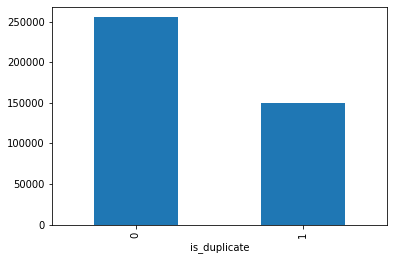

In [8]:
train.groupby("is_duplicate")['id'].count().plot.bar()

In [9]:
print("total number of questions in dataset are:- {}".format(len(train)))

total number of questions in dataset are:- 404290


In [10]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(round(len(train[train['is_duplicate']==0])/len(train) * 100),2))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(len(train[train['is_duplicate']==1])/len(train) * 100),2))

~> Question pairs are not Similar (is_duplicate = 0):
   63%

~> Question pairs are Similar (is_duplicate = 1):
   37%


In [11]:
#store all the question ids in a list 'qids'
qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())

#get the unique qids by using np.unique on qids
unique_qs = len(np.unique(qids))

#get the sum of those qids which repeat more than one
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total number of  Unique Questions are: {}'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}'.format(max(qids.value_counts()))) 

Total number of  Unique Questions are: 537933
Number of unique questions that appear more than one time: 111780 (20.77953945937505%)
Max number of times a single question is repeated: 157


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



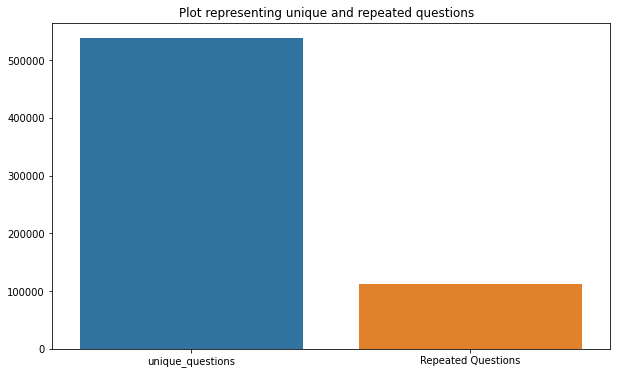

In [12]:
x = ["unique_questions" , "Repeated Questions"]
y = [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [13]:
#checking for duplicate pairs by grouping on qid1 and qid2.
duplicate_pairs = train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("total number of duplicate questions: {}".format(duplicate_pairs.shape[0] - train.shape[0])) 

total number of duplicate questions: 0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning:

The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



Maximum number of times a single question is repeated: 157



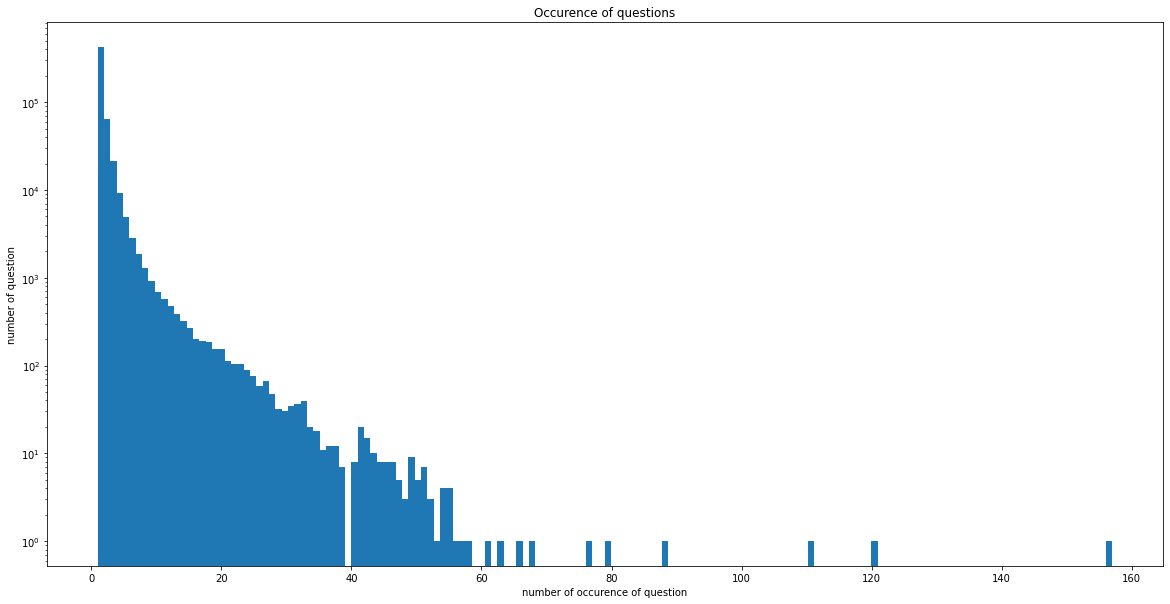

In [14]:
#plot occurences of questions
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=160)

plt.yscale('log', nonposy='clip')

plt.title("Occurence of questions")
plt.xlabel("number of occurence of question")
plt.ylabel("number of question")

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [15]:
#check for null values in an entire dataframe
null_rows = train[train.isnull().any(axis = 1)]
null_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [16]:
#fill the nan values with a space
train = train.fillna(" ")
null_rows = train[train.isnull().any(axis = 1)]
print(null_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


**Basic Feature Extraction before cleaning**
* **freq_qid1** = Frequency of qid1's
* freq_qid2 = Frequency of qid2's
* q1len = Length of q1
* q2len = Length of q2
* q1_n_words = Number of words in Question 1
* q2_n_words = Number of words in Question 2
* word_Common = (Number of common unique words in Question 1 and Question 2)
* word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
* word_share = (word_common)/(word_Total)
* freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
* freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [17]:
train['freq_qid1'] = train.groupby('qid1')['qid1'].transform('count') 
train['freq_qid2'] = train.groupby('qid2')['qid2'].transform('count')

train['q1len'] = train['question1'].astype(str).str.len()
train['q2len'] = train['question2'].astype(str).str.len()

train['q1_n_words'] = train['question1'].astype(str).apply(lambda row : len(row.split(" ")))
train['q2_n_words'] = train['question2'].astype(str).apply(lambda row : len(row.split(" ")))

In [18]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7


In [19]:
train.values

array([[0, 1, 2, ..., 57, 14, 12],
       [1, 3, 4, ..., 88, 8, 13],
       [2, 5, 6, ..., 59, 14, 10],
       ...,
       [404287, 537928, 537929, ..., 17, 4, 3],
       [404288, 537930, 537931, ..., 127, 17, 25],
       [404289, 537932, 537933, ..., 45, 8, 10]], dtype=object)

In [20]:
train['word_Overlap'] = [set(x[3].split()) & set(x[4].split()) for x in train.values]
train['word_Common'] = train['word_Overlap'].str.len()
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Overlap,word_Common
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,"{to, guide, in, by, the, share, What, is, inve...",10
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,"{the, (Koh-i-Noor), What, Kohinoor}",4
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,"{can, speed, How}",3
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,{},0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,"{Which, in}",2


In [21]:
train['word_Total'] = train['question1'].str.split().map(len) + train['question2'].str.split().map(len)

In [22]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Overlap,word_Common,word_Total
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,"{to, guide, in, by, the, share, What, is, inve...",10,26
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,"{the, (Koh-i-Noor), What, Kohinoor}",4,21
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,"{can, speed, How}",3,24
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,{},0,20
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,"{Which, in}",2,20


In [23]:
train.drop('word_Overlap' , axis = 1, inplace = True)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,3,24
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,20
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20


In [24]:
train['word_share'] = train['word_Common'] / train['word_Total'] 

In [25]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26,0.384615
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21,0.190476
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,3,24,0.125000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,20,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000


In [26]:
train['freq_q1+q2'] = train['freq_qid1'] + train['freq_qid2']
train['freq_q1-q2'] = abs(train['freq_qid1'] - train['freq_qid2'])

In [27]:
train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26,0.384615,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21,0.190476,5,3


In [28]:
#Analysis of extracted features
print ("Minimum length of the questions in question1 : " , min(train['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(train['q2_n_words']))

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1


In [29]:
print ("Number of Questions with minimum length [question1] :", train[train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", train[train['q2_n_words']== 1].shape[0])

Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



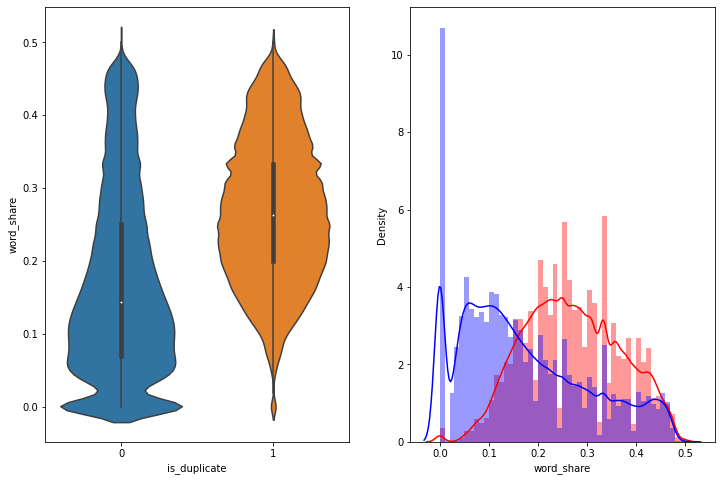

In [30]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = train[0:])

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



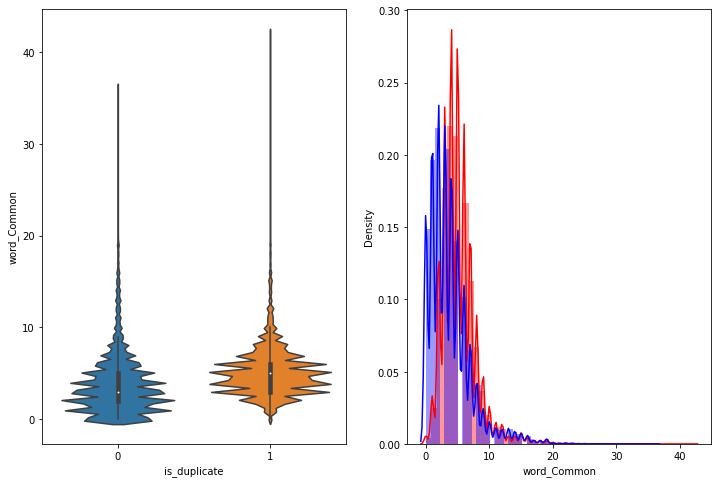

In [31]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = train[0:])

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [32]:
train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26,0.384615,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21,0.190476,5,3


## Preprocessing of Text
* Removing HTML tags
* Remove punctuation
* Stemming
* Removing stop words
* Expanding contractions

In [33]:
STOP_WORDS = stopwords.words("english")
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

In [34]:
SAFE_DIV = 0.0001

In [35]:
!pip install --user distance

     |████████████████████████████████| 180 kB 279 kB/s eta 0:00:01
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16275 sha256=150c322abf8303a35ec9432fd1e0c83a5b8ef2e4436f20e247f19e4ffeacbf4a
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance


In [36]:
def get_token_features(q1, q2):
    
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)    #cwc_min
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)    #cwc_max
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)    #csc_min
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)    #csc_max
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV) #ctc_min
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV) #ctc_max
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])  #last_word_eq
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])    #first_word_eq
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))  #abs_len_diff
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2   #mean_len
    return token_features

# get the Longest Common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [37]:
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [38]:
train = extract_features(train)
train.head()

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


# Analysis of Extracted Features

In [39]:
train_duplicate = train[train['is_duplicate'] == 1]
train_nonduplicate = train[train['is_duplicate'] == 0]

In [40]:
# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([train_duplicate["question1"], train_duplicate["question2"]]).flatten()
n = np.dstack([train_nonduplicate["question1"], train_nonduplicate["question2"]]).flatten()

In [41]:
print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [42]:
#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

In [43]:
# reading the text files and removing the Stop Words:
#d = path.dirname('.')

textp_w = open('train_p.txt').read()
textn_w = open('train_n.txt').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


Word Cloud for Duplicate Question pairs


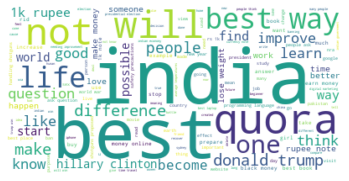

In [44]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Non Duplicate Question pairs


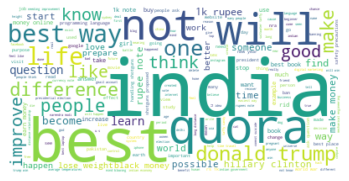

In [45]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Non Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

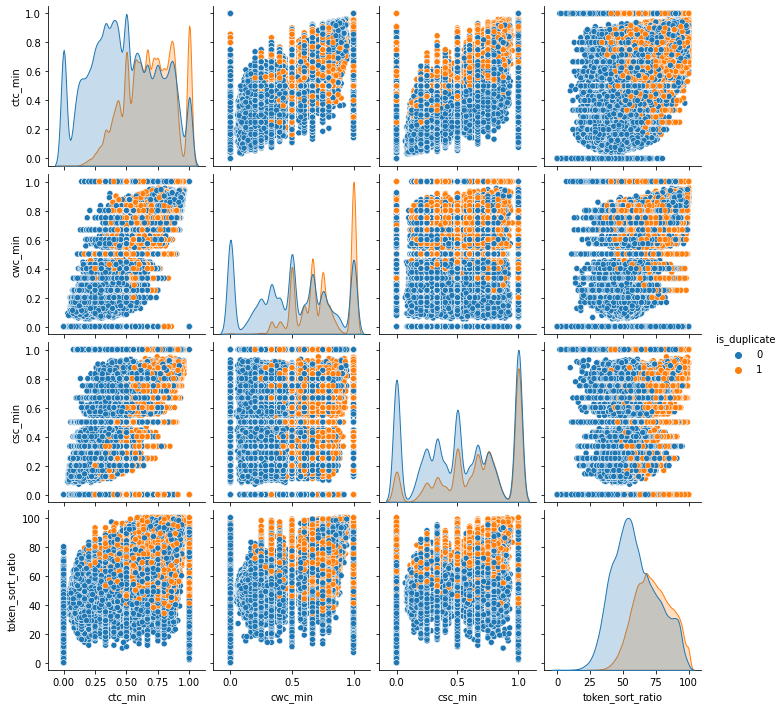

In [46]:
n = train.shape[0]
sns.pairplot(train[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [47]:
train.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



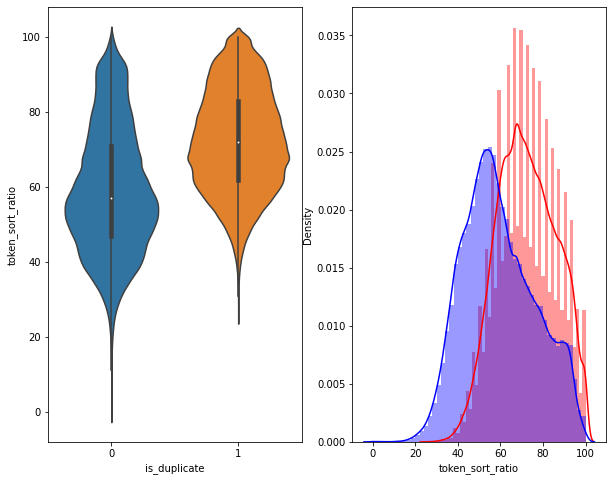

In [48]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = train[0:] , )

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



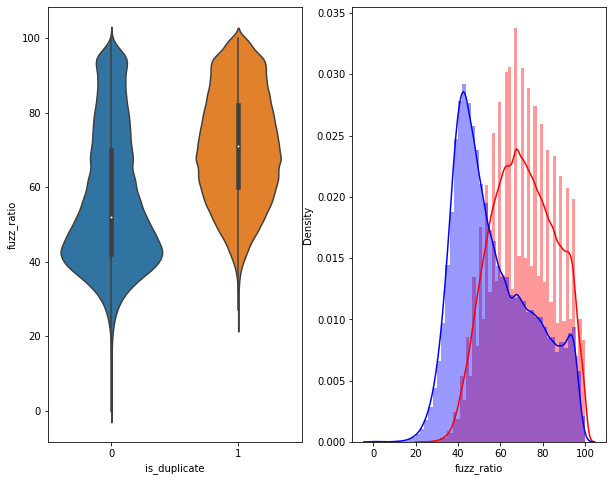

In [49]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = train[0:] , )

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [50]:
train.shape

(404290, 32)

In [51]:
train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


In [52]:
y = train['is_duplicate']

In [53]:
#train.drop('is_duplicate',inplace = True,axis = 1)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(270874, 32)
(133416, 32)
(270874,)
(133416,)


In [54]:
x_train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
316451,316451,441499,441500,what is the tattoo written on dmc own head,were tattoos part of the 60 own hippie culture,0,1,1,41,45,...,0.22222,0.0,0.0,0.0,9.0,57,57,50,53,0.181818


In [55]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [56]:
questions = x_train['question1'] + x_train['question2']

In [57]:
i = 0
list_of_sentence = []
for sentence in questions:
    list_of_sentence.append(sentence)

In [58]:
import nltk

In [59]:
list_of_sentence = [nltk.word_tokenize(sent) for sent in list_of_sentence]

In [60]:
import gensim
#from gensim.models import Word2Vec
w2vmodel = gensim.models.Word2Vec(list_of_sentence,min_count = 5, vector_size = 50, workers = 4)


In [61]:
print(w2vmodel.wv.most_similar('sun'))

[('moon', 0.8830787539482117), ('orbit', 0.7942822575569153), ('atmosphere', 0.7726835012435913), ('ocean', 0.7517555356025696), ('ground', 0.7395867109298706), ('earth', 0.7328158020973206), ('pluto', 0.7327122688293457), ('light', 0.7247708439826965), ('jupiter', 0.7229142785072327), ('gravity', 0.719971239566803)]


In [62]:
print(w2vmodel.wv.most_similar('best'))

[('easiest', 0.7296032905578613), ('fastest', 0.6884370446205139), ('cheapest', 0.6811003088951111), ('safest', 0.666966438293457), ('good', 0.6296239495277405), ('recommended', 0.586203396320343), ('worst', 0.5835617184638977), ('proper', 0.5490056276321411), ('healthiest', 0.5479470491409302), ('coolest', 0.5371730923652649)]


In [63]:
w2v_words = list(w2vmodel.wv.key_to_index)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  25146
sample words  ['the', 'what', 'is', 'i', 'how', 'a', 'to', 'in', 'do', 'of', 'are', 'and', 'can', 'for', 'you', 'why', 'it', 'my', 'best', 'on', 'does', 'or', 'have', 'be', 'which', 'if', 'not', 'some', 'that', 'with', 'get', 'should', 'an', 'from', 'your', 'will', 'india', 'own', 'people', 'who', 'when', 'like', 'at', 'good', 'would', 'there', 'as', 'about', 'between', 'one']


In [64]:
i = 0
list_of_sentences = []
for sentence in questions:
    list_of_sentences.append(sentence)

In [65]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=10)
tf_idf_vect.fit(list_of_sentences)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(list_of_sentences)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['00', '000', '00k', '01', '04', '05', '06', '08', '09', '10']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (270874, 15258)
the number of unique words including both unigrams and bigrams  15258


In [66]:
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [67]:
dictionary['step']

7.640115825704886

In [68]:
q1_feat = [nltk.word_tokenize(sent) for sent in x_train['question1']]
q2_feat = [nltk.word_tokenize(sent) for sent in x_train['question2']]

In [69]:
x_train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
316451,316451,441499,441500,what is the tattoo written on dmc own head,were tattoos part of the 60 own hippie culture,0,1,1,41,45,...,0.22222,0.0,0.0,0.0,9.0,57,57,50,53,0.181818


In [70]:
import tqdm  
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_q1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm.tqdm(q1_feat): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    #print(sent)
    for word in sent: # for each word in a review/sentence
        #print('each word')
        #print(word)
        if word in w2v_words and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            #print('vector')
            #print(vec)
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_q1.append(sent_vec)
    row += 1

100%|██████████| 270874/270874 [14:31<00:00, 310.92it/s]


In [71]:
tfidf_sent_vectors_q1[0:2]

[array([-5.98436555e-01,  6.80295807e-01,  2.66128923e-01, -4.63618863e-01,
         8.14031834e-02, -3.15354728e-01,  6.82510918e-01,  5.48157712e-01,
        -3.72250797e-01, -4.91490091e-01, -3.97712689e-01,  2.28903918e-01,
        -6.53010317e-01, -1.12292076e+00, -4.81089024e-01,  3.43065531e-02,
         1.60202467e-02, -3.44267997e-01,  4.08204829e-01, -4.17505233e-01,
         8.56594673e-01, -1.04098093e-01,  7.18930696e-01, -6.24876954e-01,
         5.56167548e-01, -9.91467451e-01, -2.38282296e-01, -4.50929628e-01,
        -8.28229950e-01, -2.51997297e-01, -2.44754684e-01, -3.04440158e-01,
         5.58062654e-01, -2.07904689e-01,  1.56934381e+00,  7.53551450e-04,
        -1.65682640e-01, -2.01600725e-03, -2.64864325e-01, -3.89459048e-01,
         7.19400926e-01, -2.61966596e-01,  1.01274216e+00,  1.89779119e-01,
        -1.44644294e-01, -7.29198337e-01, -5.33501339e-01, -2.36433463e-01,
         9.44504058e-03,  1.54554270e-01]),
 array([ 0.27104515,  0.70413939, -0.7876883

In [72]:
import tqdm  
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_q2 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm.tqdm(q2_feat): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    #print(sent)
    for word in sent: # for each word in a review/sentence
        #print('each word')
        #print(word)
        if word in w2v_words and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            #print('vector')
            #print(vec)
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_q2.append(sent_vec)
    row += 1

100%|██████████| 270874/270874 [14:42<00:00, 306.84it/s]


In [73]:
tfidf_sent_vectors_q2[0:2]

[array([-0.93951946,  0.47759344, -0.08070057, -0.51405031, -0.221426  ,
        -0.37750056,  0.18489776,  0.10271163, -0.86346801, -0.89572432,
         0.92129636,  0.53171213, -0.18378515, -0.81827961, -0.44755928,
         0.07006925,  0.18376829, -0.14293895, -0.25384942, -0.42658373,
         0.93229615,  1.61770954,  0.1046841 , -0.42315855,  0.97030767,
         0.70959161,  0.90071541, -0.14813238,  0.17287302,  0.35233367,
         0.49222961, -0.50191074, -0.04940916, -0.52007566,  0.83477259,
        -0.03738815, -0.31406927,  0.17790535,  0.09004352, -1.22636448,
         0.17146726, -0.62245834, -0.10292496, -0.12632599, -0.9093545 ,
        -0.61400862,  0.95067287, -0.15250758,  0.47320141, -0.66210055]),
 array([ 0.38190171,  0.77344326, -0.42305877, -0.87422065, -0.39195191,
        -0.08049397,  1.34569409,  0.29353045, -1.35803988,  0.49281462,
         1.43800123,  0.70728923, -0.74223742, -1.390912  ,  0.95813717,
        -0.18950712,  0.39273035,  0.53799147, -0

In [74]:
df = pd.DataFrame()
df['q1_feat'] = list(tfidf_sent_vectors_q1)

In [75]:
df.head()

,q1_feat
0,"[-0.5984365548747953, 0.6802958070895391, 0.26..."
1,"[0.2710451527420524, 0.704139393434084, -0.787..."
2,"[-0.09903796190576243, 0.16009979106678887, 0...."
3,"[0.3021441219593366, 1.0527522277824224, -0.00..."
4,"[0.023403769443311923, 0.22852389572287962, -0..."


In [76]:
df['q2_feat'] = list(tfidf_sent_vectors_q2)
df.head()

,q1_feat,q2_feat
0,"[-0.5984365548747953, 0.6802958070895391, 0.26...","[-0.939519456750633, 0.4775934419218291, -0.08..."
1,"[0.2710451527420524, 0.704139393434084, -0.787...","[0.3819017078453124, 0.7734432609334275, -0.42..."
2,"[-0.09903796190576243, 0.16009979106678887, 0....","[-2.803073818883104, -0.2662749747856121, 0.12..."
3,"[0.3021441219593366, 1.0527522277824224, -0.00...","[-0.22717876380629243, 0.35627263411780047, 0...."
4,"[0.023403769443311923, 0.22852389572287962, -0...","[0.698009230646939, -0.2459778545532759, 0.054..."


In [77]:
df3_q1 = pd.DataFrame(df.q1_feat.values.tolist(), index= df.index)
df3_q2 = pd.DataFrame(df.q2_feat.values.tolist(), index= df.index)

In [78]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.598437,0.680296,0.266129,-0.463619,0.081403,-0.315355,0.682511,0.548158,-0.372251,-0.491490,...,0.719401,-0.261967,1.012742,0.189779,-0.144644,-0.729198,-0.533501,-0.236433,0.009445,0.154554
1,0.271045,0.704139,-0.787688,-0.261338,-0.507448,-0.316978,1.449677,-0.095962,-0.885902,0.206487,...,3.602962,0.510594,-0.253332,-0.436483,0.881105,0.117558,0.211013,0.181994,0.410828,0.699045
2,-0.099038,0.160100,0.757512,-0.722352,-1.387524,1.147096,-0.189523,0.350013,0.229162,0.545678,...,2.383756,-0.410926,-0.656844,-0.303315,0.198355,-1.151365,0.831390,-0.856816,0.788627,-1.094982
3,0.302144,1.052752,-0.002552,0.064107,-0.808929,-0.262365,-0.047669,0.128593,-0.224621,-0.908308,...,0.494207,-0.038661,0.468166,-0.946800,-0.314868,-0.397846,0.004152,-0.669374,0.448254,-0.480732
4,0.023404,0.228524,-0.645448,0.255085,-0.138337,-0.126591,-0.430362,0.467564,0.386963,-0.761655,...,0.320716,-0.172347,-0.194320,0.015217,-0.335410,-0.761225,-0.039584,-0.810440,-0.121818,-0.381301


In [79]:
x_train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
316451,316451,441499,441500,what is the tattoo written on dmc own head,were tattoos part of the 60 own hippie culture,0,1,1,41,45,...,0.22222,0.0,0.0,0.0,9.0,57,57,50,53,0.181818


In [80]:
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.939519,0.477593,-0.080701,-0.514050,-0.221426,-0.377501,0.184898,0.102712,-0.863468,-0.895724,...,0.171467,-0.622458,-0.102925,-0.126326,-0.909354,-0.614009,0.950673,-0.152508,0.473201,-0.662101
1,0.381902,0.773443,-0.423059,-0.874221,-0.391952,-0.080494,1.345694,0.293530,-1.358040,0.492815,...,3.624183,1.174190,-0.385604,-0.063790,1.589962,0.696602,0.743084,0.126920,-0.053831,0.770335
2,-2.803074,-0.266275,0.126224,1.140134,0.129554,-0.451417,2.118543,2.075013,-1.599711,-0.955014,...,-0.986711,-0.713741,0.053378,0.580263,-1.307663,-1.119653,0.570711,0.728214,-0.688686,1.346190
3,-0.227179,0.356273,0.186260,-0.081866,-0.575402,0.108111,0.521291,0.329930,-0.102176,-1.063430,...,0.541929,0.117037,0.403776,-0.096627,0.017178,-0.473524,0.392720,-0.356159,0.976273,-0.329055
4,0.698009,-0.245978,0.054953,-0.252019,-0.638760,-0.024837,0.154021,1.230379,0.304509,0.826122,...,0.054839,-0.285225,-0.174310,-0.447548,-0.178955,-0.455106,-0.304233,-0.585604,0.101837,-0.396675


In [81]:
x_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [82]:
x_train.drop(['qid1', 'qid2', 'question1', 'question2'],inplace = True, axis = 1)
#train.head

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
x_train.head(1)

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
316451,316451,0,1,1,41,45,8,8,1,16,...,0.22222,0.0,0.0,0.0,9.0,57,57,50,53,0.181818


In [ ]:
x_train = x_train.reset_index()
x_train.head()

,index,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,316451,316451,0,1,1,41,45,8,8,1,...,0.222220,0.0,0.0,0.0,9.0,57,57,50,53,0.181818
1,398368,398368,1,1,1,59,69,11,12,6,...,0.583328,0.0,1.0,1.0,11.5,93,82,67,66,0.433333
2,218253,218253,0,1,1,21,47,5,8,0,...,0.000000,0.0,0.0,3.0,6.5,41,41,34,43,0.136364
3,282919,282919,0,1,1,43,23,6,4,1,...,0.499992,0.0,0.0,2.0,5.0,87,55,54,78,0.750000
4,243365,243365,0,1,1,52,69,9,14,0,...,0.071428,0.0,0.0,5.0,11.5,50,50,44,52,0.150943


In [ ]:
df3_q1['id']= x_train['id']
df3_q2['id']= x_train['id']
#result  = df1.merge(df2, on='id',how='left')

In [ ]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,id
0,-0.598437,0.680296,0.266129,-0.463619,0.081403,-0.315355,0.682511,0.548158,-0.372251,-0.491490,...,-0.261967,1.012742,0.189779,-0.144644,-0.729198,-0.533501,-0.236433,0.009445,0.154554,316451
1,0.271045,0.704139,-0.787688,-0.261338,-0.507448,-0.316978,1.449677,-0.095962,-0.885902,0.206487,...,0.510594,-0.253332,-0.436483,0.881105,0.117558,0.211013,0.181994,0.410828,0.699045,398368
2,-0.099038,0.160100,0.757512,-0.722352,-1.387524,1.147096,-0.189523,0.350013,0.229162,0.545678,...,-0.410926,-0.656844,-0.303315,0.198355,-1.151365,0.831390,-0.856816,0.788627,-1.094982,218253
3,0.302144,1.052752,-0.002552,0.064107,-0.808929,-0.262365,-0.047669,0.128593,-0.224621,-0.908308,...,-0.038661,0.468166,-0.946800,-0.314868,-0.397846,0.004152,-0.669374,0.448254,-0.480732,282919
4,0.023404,0.228524,-0.645448,0.255085,-0.138337,-0.126591,-0.430362,0.467564,0.386963,-0.761655,...,-0.172347,-0.194320,0.015217,-0.335410,-0.761225,-0.039584,-0.810440,-0.121818,-0.381301,243365


In [ ]:
x_train  = x_train.merge(df3_q1, on='id',how='left')
x_train = x_train.merge(df3_q2, on='id',how='left')

In [ ]:
x_train.head(5)

,index,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,316451,316451,0,1,1,41,45,8,8,1,...,0.171467,-0.622458,-0.102925,-0.126326,-0.909354,-0.614009,0.950673,-0.152508,0.473201,-0.662101
1,398368,398368,1,1,1,59,69,11,12,6,...,3.624183,1.174190,-0.385604,-0.063790,1.589962,0.696602,0.743084,0.126920,-0.053831,0.770335
2,218253,218253,0,1,1,21,47,5,8,0,...,-0.986711,-0.713741,0.053378,0.580263,-1.307663,-1.119653,0.570711,0.728214,-0.688686,1.346190
3,282919,282919,0,1,1,43,23,6,4,1,...,0.541929,0.117037,0.403776,-0.096627,0.017178,-0.473524,0.392720,-0.356159,0.976273,-0.329055
4,243365,243365,0,1,1,52,69,9,14,0,...,0.054839,-0.285225,-0.174310,-0.447548,-0.178955,-0.455106,-0.304233,-0.585604,0.101837,-0.396675


In [ ]:
x_train.drop('index',inplace=True,axis = 1)

In [ ]:
x_train.head(1)

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,316451,0,1,1,41,45,8,8,1,16,...,0.171467,-0.622458,-0.102925,-0.126326,-0.909354,-0.614009,0.950673,-0.152508,0.473201,-0.662101


In [ ]:
x_test.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,2,2,34,34,...,0.874989,0.0,1.0,0.0,8.0,90,81,88,88,0.800000
368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,5,2,53,51,...,0.545450,0.0,1.0,2.0,10.0,73,73,73,73,0.326923


In [ ]:
q1_feat_tst = [nltk.word_tokenize(sent) for sent in x_test['question1']]
q2_feat_tst = [nltk.word_tokenize(sent) for sent in x_test['question2']]

In [ ]:
import tqdm  
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_q1_tst = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm.tqdm(q1_feat_tst): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    #print(sent)
    for word in sent: # for each word in a review/sentence
        #print('each word')
        #print(word)
        if word in w2v_words and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            #print('vector')
            #print(vec)
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_q1_tst.append(sent_vec)
    row += 1

100%|██████████| 133416/133416 [07:03<00:00, 315.40it/s]


In [ ]:
import tqdm  
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_q2_tst = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm.tqdm(q2_feat_tst): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    #print(sent)
    for word in sent: # for each word in a review/sentence
        #print('each word')
        #print(word)
        if word in w2v_words and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            #print('vector')
            #print(vec)
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_q2_tst.append(sent_vec)
    row += 1

100%|██████████| 133416/133416 [07:11<00:00, 309.43it/s]


In [ ]:
tfidf_sent_vectors_q1_tst[0]

array([-0.07096879,  0.35113594,  0.54013599,  1.46985076, -0.8866554 ,
       -0.03179892,  0.8475521 ,  1.19090904,  0.02636663,  1.08649249,
       -0.16365399, -1.04629898, -0.43813628, -0.18111236, -1.65582559,
       -0.55044996, -0.2975661 ,  0.28416789,  0.5177918 , -0.48603527,
       -0.25751335, -0.23008547, -0.02278357,  1.13778636, -0.99953521,
       -0.0772806 ,  0.98795945,  0.02060707, -0.89603048,  1.10079308,
        0.40677761,  0.83692063,  0.50442683, -1.02425191, -0.04181286,
       -0.45977238, -0.34176547,  0.55919263,  1.5425061 , -0.93926561,
       -0.25292776,  0.54071745, -0.89253267, -0.27232361, -0.92315302,
       -2.7812782 ,  0.20193803, -0.85544145, -0.52652816, -1.01418301])

In [ ]:
df = pd.DataFrame()
df['q1_feat'] = list(tfidf_sent_vectors_q1_tst)
#df = pd.DataFrame()
df['q2_feat'] = list(tfidf_sent_vectors_q2_tst)

In [ ]:
df.head()

,q1_feat,q2_feat
0,"[-0.07096878613797515, 0.35113594201277776, 0....","[0.1598023239485537, 0.44794367256672624, 0.57..."
1,"[0.2964656418293176, 0.3789476986998514, -0.27...","[0.43146328459459743, 0.8753224980728871, 0.14..."
2,"[0.658820443600863, 0.604212300916183, -0.3611...","[-0.5186927296028246, -0.35645054751337185, -1..."
3,"[-1.5737155101481348, 0.1723675466535724, -0.0...","[-0.906078795880411, -0.052879523763190536, -0..."
4,"[-0.5813461103384937, -0.1774017102206707, 0.2...","[-1.3620729661818942, 0.29372741031730726, 0.6..."


In [ ]:
df3_q1 = pd.DataFrame(df.q1_feat.values.tolist(), index= df.index)
df3_q2 = pd.DataFrame(df.q2_feat.values.tolist(), index= df.index)

In [ ]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.070969,0.351136,0.540136,1.469851,-0.886655,-0.031799,0.847552,1.190909,0.026367,1.086492,...,-0.252928,0.540717,-0.892533,-0.272324,-0.923153,-2.781278,0.201938,-0.855441,-0.526528,-1.014183
1,0.296466,0.378948,-0.276934,0.520341,-0.259205,-0.428120,0.590415,0.779937,0.003026,0.073545,...,1.717671,0.984723,-0.226510,-0.245542,0.401824,0.149961,0.462535,-0.471225,0.508415,0.729573
2,0.658820,0.604212,-0.361137,0.318181,-0.277158,-0.341700,-0.284131,0.281320,0.404412,-0.327222,...,-0.423802,0.678988,0.270049,-1.233334,0.462449,-0.369459,-0.017698,-0.073110,-0.618259,0.266678
3,-1.573716,0.172368,-0.062508,-0.589436,-1.513358,-0.067314,-0.096786,1.620618,-0.839026,1.449044,...,-0.146057,-0.265529,-0.453158,-3.604478,0.298862,0.406126,1.077787,1.831540,-1.003915,0.307226
4,-0.581346,-0.177402,0.230704,-0.325811,-0.406581,0.539333,0.345426,1.365023,-0.506920,-0.206072,...,1.114143,-0.105794,-0.731949,-1.082570,-1.986056,-1.852186,0.241851,-1.193210,0.903641,-0.720913


In [ ]:
x_test = x_test.reset_index()
x_test.head()

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,2,2,34,...,0.874989,0.0,1.0,0.0,8.0,90,81,88,88,0.800000
1,368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,5,2,53,...,0.545450,0.0,1.0,2.0,10.0,73,73,73,73,0.326923
2,70497,70497,121486,121487,which is more advisable and better material fo...,what is the best server setup for buddypress,0,1,1,96,...,0.124999,0.0,0.0,8.0,12.0,41,39,39,44,0.108696
3,226567,226567,254474,258192,how do i improve logical programming skills,how can i improve my logical skills for progra...,1,2,2,44,...,0.666659,0.0,1.0,2.0,8.0,96,89,72,68,0.288889
4,73186,73186,48103,3062,how close we are to see 3rd world war,how close is a world war iii,1,4,31,38,...,0.444440,0.0,1.0,2.0,8.0,81,71,68,62,0.366667


In [ ]:
df3_q1['id']= x_test['id']
df3_q2['id']= x_test['id']
#result  = df1.merge(df2, on='id',how='left')

In [ ]:
x_test = x_test.merge(df3_q1, on='id',how='left')
x_test = x_test.merge(df3_q2, on='id',how='left')

In [ ]:
x_test.head(2)

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,2,2,34,...,-0.224412,0.752023,-0.766393,-0.613257,-1.284422,-2.459512,0.461337,-0.676409,-0.197344,-1.291861
1,368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,5,2,53,...,2.230214,1.302682,-0.183187,-0.270828,0.380807,-0.276740,0.449721,-0.801302,0.023383,0.836777


In [ ]:
x_test.columns

Index(['index', 'id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len',
       ...
       '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y', '47_y', '48_y',
       '49_y'],
      dtype='object', length=133)

In [ ]:
x_train.columns

Index(['id', 'is_duplicate', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total',
       ...
       '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y', '47_y', '48_y',
       '49_y'],
      dtype='object', length=128)

In [ ]:
x_test.drop(['index','qid1', 'qid2', 'question1', 'question2'],axis = 1, inplace = True)

In [ ]:
x_test.columns

Index(['id', 'is_duplicate', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total',
       ...
       '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y', '47_y', '48_y',
       '49_y'],
      dtype='object', length=128)

In [ ]:
x_test.drop('id',inplace = True,axis = 1)
x_train.drop('id',inplace = True,axis = 1)

In [ ]:
x_train.head()

,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,0,1,1,41,45,8,8,1,16,0.06250,...,0.171467,-0.622458,-0.102925,-0.126326,-0.909354,-0.614009,0.950673,-0.152508,0.473201,-0.662101
1,1,1,1,59,69,11,12,6,23,0.26087,...,3.624183,1.174190,-0.385604,-0.063790,1.589962,0.696602,0.743084,0.126920,-0.053831,0.770335
2,0,1,1,21,47,5,8,0,13,0.00000,...,-0.986711,-0.713741,0.053378,0.580263,-1.307663,-1.119653,0.570711,0.728214,-0.688686,1.346190
3,0,1,1,43,23,6,4,1,10,0.10000,...,0.541929,0.117037,0.403776,-0.096627,0.017178,-0.473524,0.392720,-0.356159,0.976273,-0.329055
4,0,1,1,52,69,9,14,0,23,0.00000,...,0.054839,-0.285225,-0.174310,-0.447548,-0.178955,-0.455106,-0.304233,-0.585604,0.101837,-0.396675


In [ ]:
x_test.head()

,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,0,2,2,34,34,8,8,7,16,0.437500,...,-0.224412,0.752023,-0.766393,-0.613257,-1.284422,-2.459512,0.461337,-0.676409,-0.197344,-1.291861
1,0,5,2,53,51,11,9,6,20,0.300000,...,2.230214,1.302682,-0.183187,-0.270828,0.380807,-0.276740,0.449721,-0.801302,0.023383,0.836777
2,0,1,1,96,45,16,8,2,24,0.083333,...,-0.042827,1.383566,0.361141,-1.348402,0.981707,0.742920,0.412454,0.606588,0.466465,0.421440
3,1,2,2,44,52,7,9,4,16,0.250000,...,-0.381071,-0.201342,-0.185896,-3.429206,0.567900,0.375442,0.526376,1.445820,-0.722107,0.089004
4,1,4,31,38,29,9,7,2,16,0.125000,...,0.794071,0.240046,-0.821288,-1.051948,-2.593969,-1.873510,-0.128223,-1.126074,1.196482,-1.217863


In [ ]:
y_train.head()

316451    0
398368    1
218253    0
282919    0
243365    0
Name: is_duplicate, dtype: int64

In [ ]:
y_test.head()

8067      0
368101    0
70497     0
226567    1
73186     1
Name: is_duplicate, dtype: int64

In [ ]:
x_train.shape

(270874, 127)

In [ ]:
x_train.drop('is_duplicate',axis = 1, inplace = True)
x_test.drop('is_duplicate',axis = 1, inplace = True)

In [ ]:
from sklearn.linear_model import SGDClassifier
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

In [ ]:
x_test.shape

(133416, 126)

In [120]:
x_test.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,2,2,34,34,8,8,7,16,0.437500,4,...,-0.224412,0.752023,-0.766393,-0.613257,-1.284422,-2.459512,0.461337,-0.676409,-0.197344,-1.291861
1,5,2,53,51,11,9,6,20,0.300000,7,...,2.230214,1.302682,-0.183187,-0.270828,0.380807,-0.276740,0.449721,-0.801302,0.023383,0.836777
2,1,1,96,45,16,8,2,24,0.083333,2,...,-0.042827,1.383566,0.361141,-1.348402,0.981707,0.742920,0.412454,0.606588,0.466465,0.421440
3,2,2,44,52,7,9,4,16,0.250000,4,...,-0.381071,-0.201342,-0.185896,-3.429206,0.567900,0.375442,0.526376,1.445820,-0.722107,0.089004
4,4,31,38,29,9,7,2,16,0.125000,35,...,0.794071,0.240046,-0.821288,-1.051948,-2.593969,-1.873510,-0.128223,-1.126074,1.196482,-1.217863


In [121]:
x_train.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,1,1,41,45,8,8,1,16,0.06250,2,...,0.171467,-0.622458,-0.102925,-0.126326,-0.909354,-0.614009,0.950673,-0.152508,0.473201,-0.662101
1,1,1,59,69,11,12,6,23,0.26087,2,...,3.624183,1.174190,-0.385604,-0.063790,1.589962,0.696602,0.743084,0.126920,-0.053831,0.770335
2,1,1,21,47,5,8,0,13,0.00000,2,...,-0.986711,-0.713741,0.053378,0.580263,-1.307663,-1.119653,0.570711,0.728214,-0.688686,1.346190
3,1,1,43,23,6,4,1,10,0.10000,2,...,0.541929,0.117037,0.403776,-0.096627,0.017178,-0.473524,0.392720,-0.356159,0.976273,-0.329055
4,1,1,52,69,9,14,0,23,0.00000,2,...,0.054839,-0.285225,-0.174310,-0.447548,-0.178955,-0.455106,-0.304233,-0.585604,0.101837,-0.396675


In [124]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [125]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteratio

For values of alpha =  1e-05 The log loss is: 0.4268072924552206


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteratio

For values of alpha =  0.0001 The log loss is: 0.45331691734785556
For values of alpha =  0.001 The log loss is: 0.4487867969480113
For values of alpha =  0.01 The log loss is: 0.42274509610802136
For values of alpha =  0.1 The log loss is: 0.43235972905145575
For values of alpha =  1 The log loss is: 0.4809704444719464
For values of alpha =  10 The log loss is: 0.5386970233751026


In [126]:
best_alpha = np.argmin(log_error_array)
print(best_alpha)

3


In [128]:
clf.classes_

array([0, 1])

In [129]:
log_error_array

[0.4268072924552206,
 0.45331691734785556,
 0.4487867969480113,
 0.42274509610802136,
 0.43235972905145575,
 0.4809704444719464,
 0.5386970233751026]

0.427
0.453
0.449
0.423
0.432
0.481
0.539


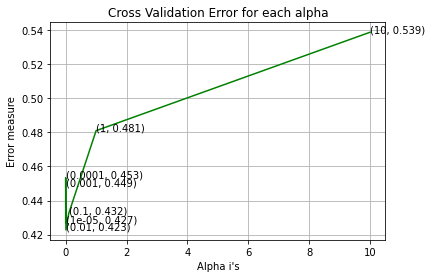

In [143]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    print(txt)
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [145]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.01, loss='log',
                                                    random_state=42))

In [148]:
predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
#plot_confusion_matrix(y_test, predicted_y)

For values of best alpha =  0.01 The train log loss is: 0.4210367071725451
For values of best alpha =  0.01 The test log loss is: 0.42274509610802136
Total number of data points : 133416


In [149]:
x_test.shape

(133416, 126)

In [150]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.44154692149750513


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteratio

For values of alpha =  0.0001 The log loss is: 0.4384327790889713


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



For values of alpha =  0.001 The log loss is: 0.4414487001965542


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



For values of alpha =  0.01 The log loss is: 0.4753190210696369
For values of alpha =  0.1 The log loss is: 0.49284894912672783


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



For values of alpha =  1 The log loss is: 0.5728195590455444


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



For values of alpha =  10 The log loss is: 0.5995056917731506


In [151]:
best_alpha = np.argmin(log_error_array)
print(best_alpha)

1


0.442
0.438
0.441
0.475
0.493
0.573
0.6


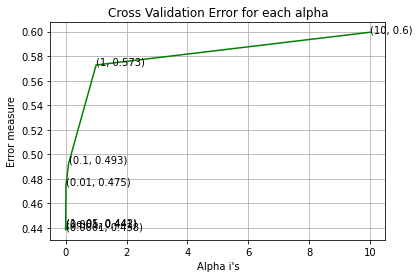

In [152]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    print(txt)
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [155]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteratio

CalibratedClassifierCV(base_estimator=SGDClassifier(penalty='l1',
                                                    random_state=42))

In [156]:
predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

For values of best alpha =  0.0001 The train log loss is: 0.43723986851603913
For values of best alpha =  0.0001 The test log loss is: 0.4384327790889713
Total number of data points : 133416


In [161]:
predict_y[5:10]

array([[0.06910936, 0.93089064],
       [0.60423754, 0.39576246],
       [0.81937128, 0.18062872],
       [0.60525802, 0.39474198],
       [0.26668079, 0.73331921]])

In [160]:
predicted_y[5:10]

array([1, 0, 0, 0, 1])

In [163]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predicted_y)

array([[73289, 10686],
       [18526, 30915]])